In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams.update({'font.size': 12})
import seaborn as sns
import cmath
import math 

from numpy.linalg import inv

def custom_plot_single(x_lst, y_lst, label_lst, xlim, ylim, label,pltname,
                       color=['k','r','b','g','o','br'],
                       linestyle=['solid','dashed','solid','dashed','solid','dashed'],
                       markertype=[None,None,'o','^','o','^'],
                       fillstyle=['none','none','none','none','full','full'],
                       linewidth=20*[3],
                       markevery=[45,30,50,40,56,72,63,95],
                       show_legend=True,
                       plt_outside=False):
    
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    fig.patch.set_facecolor('white')
    ax1.patch.set_facecolor('white')
    for p in range(0, len(x_lst)):
        ax1.plot(x_lst[p], y_lst[p], color[p],
                 linewidth=linewidth[p],
                 linestyle=linestyle[p],
                 marker=markertype[p],
                 fillstyle=fillstyle[p],
                 markevery=markevery[p],
                 markersize=8,
                 label=label_lst[p])
    if(show_legend):
        ax1.legend(prop={'size': 20},loc='best')
    ax1.tick_params(which='minor', width=2, length=4, color='k')
    ax1.tick_params(which='major', width=2, length=8, color='k')

    ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    if(show_legend):
        ax1.legend(prop={'size': 20},loc='best')#,shadow=True)

    ax1.set_ylim(ylim[0],ylim[1])
    ax1.set_xlim(xlim[0],xlim[1])
    ax1.set_xlabel(label[0], fontsize=25)#, fontdict=dict(weight='bold'))
    ax1.set_ylabel(label[1], fontsize=25)#, fontdict=dict(weight='bold'))
    fontsize=25
    for tick in ax1.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)

    for tick in ax1.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    if(plt_outside==False):
        plt.savefig(pltname, bbox_inches = "tight")
    return plt,pltname


In [2]:
PrintFigures=True
PointCharge=True

In [3]:
N=5
gamma=2.5 #eV
M=17
nano=1e-9
q=1.602e-19

U=np.zeros(N)
pt_charge_loc=np.array([0.,1*nano])
axial_loc=np.linspace(-10e-9,10e-9,N)
Q=-q #C
print('Q',q)
eps_r =1 
eps_0 = 8.85418782e-12 #F/m or C/(V.m)
if (PointCharge):
    for l in range(0, N):
        r = np.sqrt((axial_loc[l]-pt_charge_loc[0])**2 + pt_charge_loc[1]**2)
        U[l] = 1./(4.*np.pi*eps_0*eps_r) * Q/r
        #U[l] = 0
print('potential on layers:',U)
Us = U[0]
Ud = U[-1]

Q 1.602e-19
potential on layers: [-0.14326603 -0.28236915 -1.4398058  -0.28236915 -0.14326603]


In [4]:
#The following 2 functions are to create off-diagonal elements of a hamiltonian
def get_zeros_and_ones(L,lst):
    for i in range(0,L):
        if(i%2==0):
            lst.append(0)
        else:
            lst.append(1)
            
def get_ones_and_zeros(L, lst): 
    for i in range(0,L):
        if(i%2==0):
            lst.append(1)
        else:
            lst.append(0)

lst_01 = [] 
lst_10 = [] 

get_zeros_and_ones(N-1, lst_01)
get_ones_and_zeros(N-1, lst_10)

def get_beta(gamma, M, J): #overlap coefficient in mode-space approximation
    return 2*gamma*np.cos(np.pi*J/M)*np.exp(-1j*np.pi*J/M)

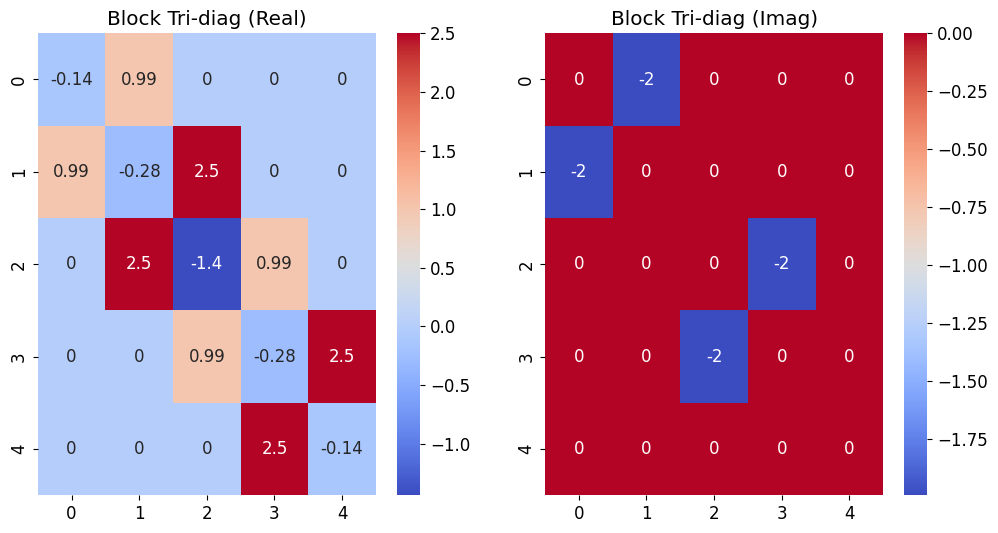

In [5]:
H_mode=np.zeros((N,N),dtype=complex)
zero_mat=np.zeros((N,N),dtype=complex)

beta = get_beta(gamma,M,6)
H_mode =U*np.diag(np.ones(N)) + gamma*np.diag(lst_01,-1)  + beta*np.diag(lst_10,-1) \
+ gamma*np.diag(lst_01,1) + beta*np.diag(lst_10,1) 

if(PrintFigures):
    #plt.figure(figsize = (8,16))
    fig, ax =plt.subplots(1,2,figsize = (12,6))
    sns.heatmap(np.real(H_mode),cmap='coolwarm',annot=True,ax=ax[0])    
    ax[0].set_title('Block Tri-diag (Real)')
    sns.heatmap(np.imag(H_mode),cmap='coolwarm',annot=True,ax=ax[1])      
    ax[1].set_title('Block Tri-diag (Imag)')

In [6]:
def BTD(M,M_inv):
    size = np.shape(M)[0]
    A=np.diag(M,0)
    B=np.diag(M,-1)
    C=np.diag(M,1)
#    M_inv = np.zeros(np.shape(M),dtype=complex)
    X_tilde=np.zeros(size,dtype=complex)
    Y_tilde=np.zeros(size,dtype=complex)
    X=np.zeros(size,dtype=complex)
    Y=np.zeros(size,dtype=complex)
    for n in range(1,size):
        Y_tilde[n] = (1./(A[n-1] - Y[n-1]))*C[n-1]
        Y[n] = B[n-1]*Y_tilde[n]
        
    for n in range(size-2,-1,-1):
        X_tilde[n] = (1./(A[n+1]-X[n+1]))*B[n]
        X[n] = C[n]*X_tilde[n]
    
    for i in range(0,size):
        M_inv[i][i] = 1./(A[i] - X[i] - Y[i])
        
    for n in range(0,size):
        for m in range(n,0,-1):
            #print(m-1,n)
            M_inv[m-1][n] = -Y_tilde[m]*M_inv[m][n]
        for m in range(n, size-1):
            #print(m+1,n)
            M_inv[m+1][n] = -X_tilde[m]*M_inv[m][n]
     
#     python_inverse=inv(H_mode)
#     if(PrintFigures):
#         #plt.figure(figsize = (12,6))
#         fig, ax =plt.subplots(2,2,figsize = (12,12))
#         sns.heatmap(np.real(M_inv),cmap='coolwarm',annot=True,ax=ax[0][0],label='hey')    
#         ax[0][0].set_title('Block Tri-diag (Real)')
#         sns.heatmap(np.imag(M_inv),cmap='coolwarm',annot=True,ax=ax[1][0])      
#         ax[1][0].set_title('Block Tri-diag (Imag)')

#         sns.heatmap(np.real(python_inverse),cmap='coolwarm',annot=True,ax=ax[0][1])  
#         ax[0][1].set_title('Python (Real)')
#         sns.heatmap(np.imag(python_inverse),cmap='coolwarm',annot=True,ax=ax[1][1])  
#         ax[1][1].set_title('Python (Imag)')


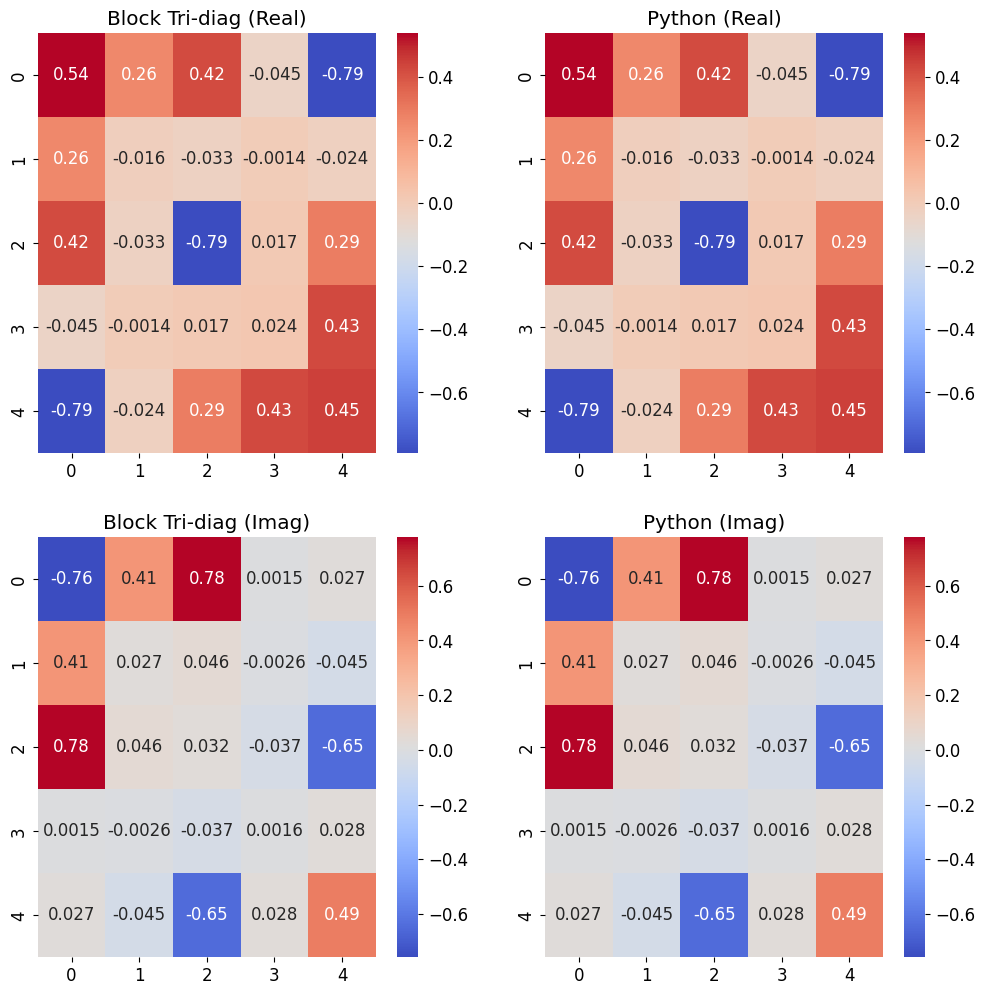

In [7]:
python_inverse=inv(H_mode)
G = np.zeros(np.shape(H_mode),dtype=complex)
BTD(H_mode,G)

if(PrintFigures):
    #plt.figure(figsize = (12,6))
    fig, ax =plt.subplots(2,2,figsize = (12,12))
    sns.heatmap(np.real(G),cmap='coolwarm',annot=True,ax=ax[0][0],label='hey')    
    ax[0][0].set_title('Block Tri-diag (Real)')
    sns.heatmap(np.imag(G),cmap='coolwarm',annot=True,ax=ax[1][0])      
    ax[1][0].set_title('Block Tri-diag (Imag)')

    sns.heatmap(np.real(python_inverse),cmap='coolwarm',annot=True,ax=ax[0][1])  
    ax[0][1].set_title('Python (Real)')
    sns.heatmap(np.imag(python_inverse),cmap='coolwarm',annot=True,ax=ax[1][1])  
    ax[1][1].set_title('Python (Imag)')